In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST, CIFAR10

# Note: we will load the IMDB dataset from tensorflow.keras...
from tensorflow.keras.datasets import imdb
import tensorflow as tf
from tensorflow import keras
import gc
from sklearn.model_selection import train_test_split

from torch.nn import Linear, Conv2d, MaxPool2d, Dropout, Flatten, ReLU
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### PyTorch version: ' + torch.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())


------------
### Python version: 3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
### NumPy version: 2.1.3
### Scikit-learn version: 1.6.1
### PyTorch version: 2.6.0+cpu
------------


In [2]:
# check if the unzipped directory exists, if not, unzip it
directory = "project_data"
zippedDir = directory + ".zip"
if not os.path.isdir(directory):
    import zipfile
    with zipfile.ZipFile(zippedDir, 'r') as myzip:
        myzip.extractall(directory)

In [3]:
from PIL import Image
from pathlib import Path
dirNames = []

def getData():
    imageCounter = 0
    images = []
    labels = []
    for classes in Path(directory).iterdir():
        dirNames.append(os.path.basename(classes))
        for image in classes.iterdir():
            imageCounter += 1
            img = np.array(Image.open(image).convert("RGB"))
            img = np.transpose(img, (2, 0, 1))
            images.append(img)
            labels.append(os.path.basename(classes))
    return np.array(images), np.array(labels), imageCounter

In [4]:
import matplotlib.pyplot as plt

def visualizeData(x, y):
    # visualize to make sure images have loaded with correct labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        # For visualization, transpose back to (H, W, C)
        img_to_show = np.transpose(x[i], (1, 2, 0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_to_show)
        plt.title(y[i])
        plt.axis("off")
    plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # shape: [N, 3, 128, 128]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype('uint8')  # shape: [3, 128, 128]
        img = np.transpose(img, (1, 2, 0))      # → [128, 128, 3] for ToPILImage
        img = ToPILImage()(img)                 # now valid
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ResNetConvNet128(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        
        # Load ResNet18 backbone, exclude final FC
        resnet = resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Keeps up to last conv block

        # Adaptive pooling to handle output size
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Output shape: (batch, 512, 1, 1)

        # Your custom classifier head
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.features(x)              # → [B, 512, H, W]
        x = self.pool(x)                  # → [B, 512, 1, 1]
        x = torch.flatten(x, 1)           # → [B, 512]
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.fc3(x)


[ 0  0  0 ... 11 11 11]


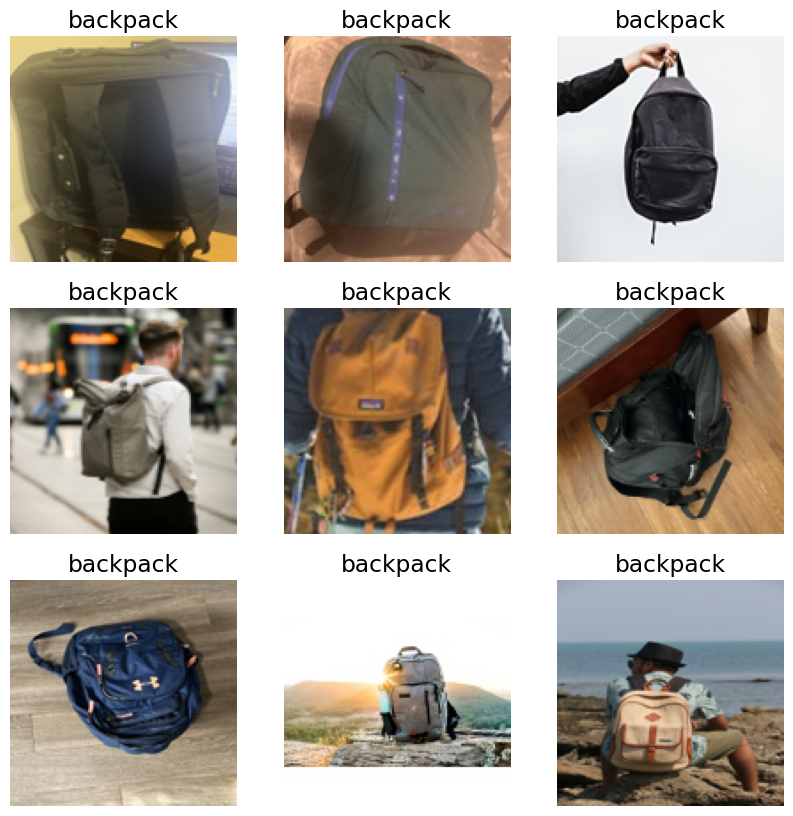

In [7]:
from sklearn.preprocessing import LabelEncoder

images, labels, count = getData()


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(labels_encoded)

visualizeData(images, labels)

In [ ]:
transform = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),  # ← Converts PIL to Tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


dataset = CustomImageDataset(images, labels_encoded, transform=train_transform)

# Split dataset into train and validation sets
val_size = 750
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader for batching
n_batch = 32
train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)

In [9]:
# Check a batch from the new train_loader
for i, data in enumerate(train_loader):
    inputs, temp = data  # inputs: [B, 3, 128, 128]

    # Ensure inputs are float tensors (they should be after ToTensor + Normalize)
    inputs = inputs.float()

    # Get global min and max across the entire batch
    min_val = inputs.min().item()
    max_val = inputs.max().item()

    if min_val < -1 or max_val > 1:
        print("Sample out of range:")
    else:
        print("All good - Images are normalized to [-1,1]")

    # Print min and max values found in the batch
    print(f"Min value in batch: {min_val:.5f}")
    print(f"Max value in batch: {max_val:.5f}")
    print(temp)

    break  # Check only the first batch


All good - Images are normalized to [-1,1]
Min value in batch: -1.00000
Max value in batch: 1.00000
tensor([10,  5,  6,  3,  6,  3,  5,  1,  1,  6,  0,  3,  2,  3,  0, 11,  0,  0,
        11,  9, 10,  6,  1,  0,  0,  2,  6,  9,  3,  4,  1,  6])


In [10]:
print(labels_encoded)

[ 0  0  0 ... 11 11 11]


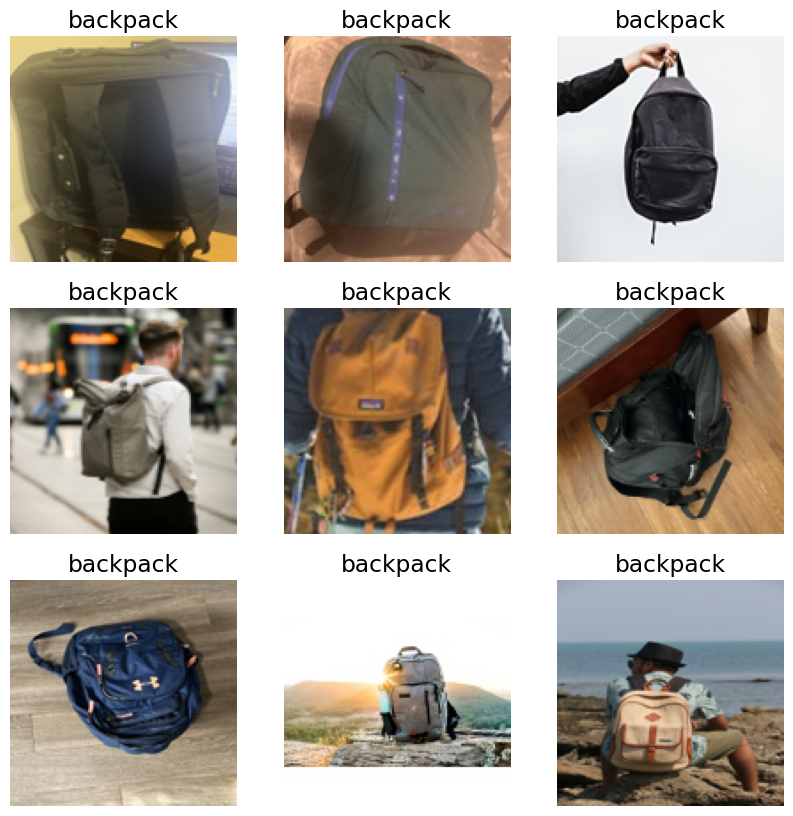

In [11]:
visualizeData(images, labels)

In [13]:
# Initialize model, cross entropy loss, and learning rate
model = ResNetConvNet128()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alexc/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [14]:
max_epochs = 10

train_loss_logs = []
val_loss_logs = []
train_acc_logs = []
val_acc_logs = []

start = time.time()
print(f"{'Epoch':<6} | {'Train Loss':<10} | {'Train Acc':<10} | {'Val Loss':<10} | {'Val Acc':<10}")
print("-" * 55)

for epoch in range(max_epochs):
    model.train(True)
    running_loss = 0.0
    running_acc = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        running_acc += torch.sum(predicted == labels)
        max_minibatch = train_size // n_batch

        if i % max_minibatch == max_minibatch - 1:
            avg_train_loss = running_loss / max_minibatch
            avg_train_acc = running_acc / (max_minibatch * n_batch)
            train_loss_logs.append(avg_train_loss)
            train_acc_logs.append(avg_train_acc)

            model.eval()
            with torch.no_grad():
                X_val, t_val = next(iter(val_loader))
                X_val = X_val.float()
                y_val = model(X_val)
                val_loss = loss_fn(y_val, t_val).item()
                _, pred_val = torch.max(y_val, 1)
                val_acc = torch.sum(pred_val == t_val).item() / val_size
                val_loss_logs.append(val_loss)
                val_acc_logs.append(val_acc)

            print(f"{epoch:<6} | {avg_train_loss:<10.3f} | {avg_train_acc:<10.3f} | {val_loss:<10.3f} | {val_acc:<10.3f}")

            running_loss = 0.0
            running_acc = 0.0

end = time.time()
print('Finished Training')
print(f'Took {(end-start)//60:.0f} minutes and {(end-start)%60:.1f} seconds')

Epoch  | Train Loss | Train Acc  | Val Loss   | Val Acc   
-------------------------------------------------------
0      | 1.697      | 0.464      | 1.394      | 0.592     
1      | 1.275      | 0.626      | 1.264      | 0.657     
2      | 1.219      | 0.656      | 1.144      | 0.671     
3      | 0.940      | 0.738      | 1.132      | 0.673     
4      | 0.846      | 0.774      | 1.018      | 0.713     
5      | 0.687      | 0.816      | 0.931      | 0.731     
6      | 0.581      | 0.850      | 1.028      | 0.732     
7      | 0.631      | 0.839      | 0.900      | 0.757     
8      | 0.476      | 0.879      | 0.801      | 0.765     
9      | 0.452      | 0.886      | 0.845      | 0.781     
Finished Training
Took 13 minutes and 32.1 seconds


New Method

Epoch  | Train Loss | Train Acc  | Val Loss   | Val Acc   
-------------------------------------------------------
0      | 2.465      | 0.113      | 2.375      | 0.268     
1      | 2.366      | 0.189      | 2.238      | 0.453     
2      | 2.236      | 0.285      | 2.046      | 0.599     
3      | 2.077      | 0.375      | 1.839      | 0.655     
4      | 1.893      | 0.454      | 1.612      | 0.703     
5      | 1.717      | 0.525      | 1.401      | 0.729     
6      | 1.560      | 0.577      | 1.234      | 0.773     
7      | 1.415      | 0.626      | 1.078      | 0.799     
8      | 1.288      | 0.666      | 0.955      | 0.837     
9      | 1.172      | 0.698      | 0.820      | 0.845     
10     | 1.070      | 0.728      | 0.711      | 0.844     
11     | 0.963      | 0.761      | 0.648      | 0.860     
12     | 0.873      | 0.788      | 0.589      | 0.869     
13     | 0.811      | 0.801      | 0.514      | 0.873     
14     | 0.768      | 0.817      | 0.500      | 0.868     
15     | 0.700      | 0.836      | 0.450      | 0.880     
16     | 0.668      | 0.840      | 0.415      | 0.891     
17     | 0.605      | 0.858      | 0.398      | 0.891     
18     | 0.562      | 0.868      | 0.391      | 0.884     
19     | 0.537      | 0.873      | 0.390      | 0.888     
20     | 0.505      | 0.882      | 0.362      | 0.897     
21     | 0.486      | 0.884      | 0.328      | 0.913     
22     | 0.459      | 0.895      | 0.321      | 0.911     
23     | 0.410      | 0.905      | 0.330      | 0.912     
24     | 0.425      | 0.901      | 0.339      | 0.901     
25     | 0.379      | 0.909      | 0.329      | 0.899     
26     | 0.396      | 0.907      | 0.325      | 0.905     
27     | 0.348      | 0.917      | 0.309      | 0.921     
28     | 0.324      | 0.925      | 0.306      | 0.915     
29     | 0.312      | 0.924      | 0.290      | 0.909     
30     | 0.285      | 0.933      | 0.304      | 0.908     
31     | 0.272      | 0.937      | 0.302      | 0.913     
32     | 0.271      | 0.939      | 0.267      | 0.928     